# Vision Transformer: Image Size Comparison (64x64 vs 128x128)

This notebook compares the performance of Vision Transformer models trained on different image resolutions:
- **64x64**: Higher resolution than original 48x48, should capture more detail
- **128x128**: Even higher resolution, but may cause overfitting with limited data

We'll train both models with identical hyperparameters and compare:
1. **Accuracy**: Final test accuracy for each model
2. **Training Time**: Time per epoch and total training time
3. **Model Size**: Number of parameters and memory usage
4. **Overfitting**: Train-validation gap analysis
5. **Convergence**: How quickly each model reaches optimal performance

## 1. Import Libraries and Setup

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
from tqdm import tqdm
import os

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Ti


## 2. Dataset Configuration

In [14]:
# Dataset paths
BASE_PATH = "/media/ubuntu/NVME/AIML project/AlphaNum2"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")

print(f"Dataset: {BASE_PATH}")
print(f"Train: {TRAIN_PATH}")
print(f"Validation: {VALIDATION_PATH}")
print(f"Test: {TEST_PATH}")

Dataset: /media/ubuntu/NVME/AIML project/AlphaNum2
Train: /media/ubuntu/NVME/AIML project/AlphaNum2/train
Validation: /media/ubuntu/NVME/AIML project/AlphaNum2/validation
Test: /media/ubuntu/NVME/AIML project/AlphaNum2/test


## 3. Shared Training Configuration

In [15]:
# Hyperparameters (same for both models)
BATCH_SIZE = 64
MAX_EPOCHS = 30
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01
EARLY_STOPPING_PATIENCE = 5
MIN_DELTA = 0.001

print("Training Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {MAX_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

Training Configuration:
  Batch Size: 64
  Max Epochs: 30
  Learning Rate: 0.0001
  Weight Decay: 0.01
  Early Stopping Patience: 5


## 4. Helper Functions

In [16]:
def load_dataset(path, transform):
    """Load dataset with sorted classes."""
    dataset = datasets.ImageFolder(root=path, transform=transform)
    classes = sorted(dataset.classes)
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    samples = [(p, class_to_idx[dataset.classes[k]]) for p, k in dataset.samples]
    dataset.classes = classes
    dataset.class_to_idx = class_to_idx
    dataset.samples = samples
    dataset.targets = [s[1] for s in samples]
    return dataset

def create_vit_model(num_classes, img_size):
    """Create Vision Transformer model."""
    model = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=False,
        num_classes=num_classes,
        img_size=img_size,
        in_chans=1  # Grayscale
    )
    return model

def train_model(model, train_loader, val_loader, device, config):
    """Train model with early stopping."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), 
                           lr=config['lr'], 
                           weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_weights = None
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_times': []
    }
    
    print(f"\nTraining {config['name']} model...")
    print("="*70)
    
    for epoch in range(config['max_epochs']):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["max_epochs"]} [Train]', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        
        # Track history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        epoch_time = time.time() - start_time
        history['epoch_times'].append(epoch_time)
        
        # Learning rate scheduling
        scheduler.step(epoch_val_loss)
        
        # Early stopping check
        if best_val_loss - epoch_val_loss > config['min_delta']:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            epochs_no_improve = 0
            best_weights = copy.deepcopy(model.state_dict())
            status = f"✓ BEST ({epoch_val_acc:.2f}%)"
        else:
            epochs_no_improve += 1
            status = f"No improve ({epochs_no_improve}/{config['patience']})"
        
        print(f"Epoch {epoch+1:2d}: Train={epoch_train_acc:.2f}% Val={epoch_val_acc:.2f}% | {status} ({epoch_time:.1f}s)")
        
        # Early stopping
        if epochs_no_improve >= config['patience']:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            break
    
    # Restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
        print(f"\n✓ Best model restored: Val Acc={best_val_acc:.2f}%")
    
    return model, history, best_val_acc

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

print("✓ Helper functions defined")

✓ Helper functions defined


## 5. Experiment 1: 64x64 Images

In [17]:
# 64x64 transforms
IMG_SIZE_64 = 64

train_transforms_64 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE_64, IMG_SIZE_64)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms_64 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE_64, IMG_SIZE_64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
print("Loading 64x64 datasets...")
train_dataset_64 = load_dataset(TRAIN_PATH, train_transforms_64)
val_dataset_64 = load_dataset(VALIDATION_PATH, val_test_transforms_64)
test_dataset_64 = load_dataset(TEST_PATH, val_test_transforms_64)

num_classes = len(train_dataset_64.classes)
print(f"Classes: {num_classes}")
print(f"Train: {len(train_dataset_64)} samples")
print(f"Validation: {len(val_dataset_64)} samples")
print(f"Test: {len(test_dataset_64)} samples")

# Create dataloaders
train_loader_64 = DataLoader(train_dataset_64, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader_64 = DataLoader(val_dataset_64, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader_64 = DataLoader(test_dataset_64, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"\nDataLoaders created (batch size: {BATCH_SIZE})")

Loading 64x64 datasets...
Classes: 53
Train: 13250 samples
Validation: 7439 samples
Test: 11423 samples

DataLoaders created (batch size: 64)


In [18]:
# Create and train 64x64 model
print("\n" + "="*70)
print("EXPERIMENT 1: 64x64 Images")
print("="*70)

model_64 = create_vit_model(num_classes, img_size=IMG_SIZE_64)
model_64 = model_64.to(device)

total_params_64 = sum(p.numel() for p in model_64.parameters())
print(f"Model Parameters: {total_params_64:,}")

config_64 = {
    'name': '64x64',
    'max_epochs': MAX_EPOCHS,
    'lr': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'patience': EARLY_STOPPING_PATIENCE,
    'min_delta': MIN_DELTA
}

start_time_64 = time.time()
model_64, history_64, best_val_acc_64 = train_model(model_64, train_loader_64, val_loader_64, device, config_64)
total_time_64 = time.time() - start_time_64

# Evaluate on test set
print("\nEvaluating on test set...")
test_acc_64 = evaluate_model(model_64, test_loader_64, device)

print("\n" + "="*70)
print(f"64x64 RESULTS:")
print(f"  Best Validation Accuracy: {best_val_acc_64:.2f}%")
print(f"  Test Accuracy: {test_acc_64:.2f}%")
print(f"  Total Training Time: {total_time_64:.1f}s ({total_time_64/60:.1f} min)")
print(f"  Avg Time/Epoch: {np.mean(history_64['epoch_times']):.1f}s")
print("="*70)


EXPERIMENT 1: 64x64 Images


/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model Parameters: 5,401,781

Training 64x64 model...


Epoch  1: Train=2.88% Val=5.30% | ✓ BEST (5.30%) (10.1s)


Epoch  2: Train=8.42% Val=5.63% | No improve (1/5) (10.3s)


Epoch  3: Train=12.44% Val=8.17% | ✓ BEST (8.17%) (10.2s)


Epoch  4: Train=17.46% Val=8.85% | No improve (1/5) (10.1s)


Epoch  5: Train=24.98% Val=10.36% | ✓ BEST (10.36%) (10.4s)


Epoch  6: Train=32.55% Val=11.76% | ✓ BEST (11.76%) (10.1s)


Epoch  7: Train=40.37% Val=27.01% | ✓ BEST (27.01%) (10.1s)


Epoch  8: Train=46.62% Val=19.37% | No improve (1/5) (10.0s)


Epoch  9: Train=50.54% Val=46.75% | ✓ BEST (46.75%) (10.0s)


Epoch 10: Train=54.80% Val=37.25% | No improve (1/5) (10.2s)


Epoch 11: Train=58.52% Val=37.25% | No improve (2/5) (10.2s)


Epoch 12: Train=61.58% Val=40.88% | No improve (3/5) (10.3s)


Epoch 13: Train=64.10% Val=63.36% | ✓ BEST (63.36%) (10.1s)


Epoch 14: Train=66.10% Val=66.77% | ✓ BEST (66.77%) (9.9s)


Epoch 15: Train=69.58% Val=68.69% | ✓ BEST (68.69%) (10.1s)


Epoch 16: Train=70.84% Val=65.53% | No improve (1/5) (10.2s)


Epoch 17: Train=72.43% Val=62.37% | No improve (2/5) (11.5s)


Epoch 18: Train=71.60% Val=68.91% | ✓ BEST (68.91%) (11.9s)


Epoch 19: Train=74.06% Val=71.10% | ✓ BEST (71.10%) (12.0s)


Epoch 20: Train=74.91% Val=70.18% | ✓ BEST (70.18%) (11.7s)


Epoch 21: Train=76.29% Val=74.66% | ✓ BEST (74.66%) (11.8s)


Epoch 22: Train=76.91% Val=73.63% | No improve (1/5) (11.9s)


Epoch 23: Train=78.27% Val=75.83% | ✓ BEST (75.83%) (12.1s)


Epoch 24: Train=79.06% Val=77.62% | ✓ BEST (77.62%) (11.8s)


Epoch 25: Train=78.68% Val=74.70% | No improve (1/5) (12.0s)


Epoch 26: Train=79.31% Val=72.29% | No improve (2/5) (11.9s)


Epoch 27: Train=79.02% Val=77.21% | ✓ BEST (77.21%) (11.7s)


Epoch 28: Train=80.48% Val=79.37% | ✓ BEST (79.37%) (12.0s)


Epoch 29: Train=80.38% Val=78.17% | No improve (1/5) (12.0s)


Epoch 30: Train=81.21% Val=78.79% | No improve (2/5) (11.9s)

✓ Best model restored: Val Acc=79.37%

Evaluating on test set...



64x64 RESULTS:
  Best Validation Accuracy: 79.37%
  Test Accuracy: 78.88%
  Total Training Time: 328.6s (5.5 min)
  Avg Time/Epoch: 10.9s


## 6. Experiment 2: 128x128 Images

In [19]:
# 128x128 transforms
IMG_SIZE_128 = 48

train_transforms_128 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE_128, IMG_SIZE_128)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms_128 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE_128, IMG_SIZE_128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
print("Loading 128x128 datasets...")
train_dataset_128 = load_dataset(TRAIN_PATH, train_transforms_128)
val_dataset_128 = load_dataset(VALIDATION_PATH, val_test_transforms_128)
test_dataset_128 = load_dataset(TEST_PATH, val_test_transforms_128)

print(f"Train: {len(train_dataset_128)} samples")
print(f"Validation: {len(val_dataset_128)} samples")
print(f"Test: {len(test_dataset_128)} samples")

# Create dataloaders
train_loader_128 = DataLoader(train_dataset_128, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader_128 = DataLoader(val_dataset_128, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"\nDataLoaders created (batch size: {BATCH_SIZE})")

Loading 128x128 datasets...
Train: 13250 samples
Validation: 7439 samples
Test: 11423 samples

DataLoaders created (batch size: 64)


In [20]:
# Create and train 128x128 model
print("\n" + "="*70)
print("EXPERIMENT 2: 128x128 Images")
print("="*70)

model_128 = create_vit_model(num_classes, img_size=IMG_SIZE_128)
model_128 = model_128.to(device)

total_params_128 = sum(p.numel() for p in model_128.parameters())
print(f"Model Parameters: {total_params_128:,}")

config_128 = {
    'name': '128x128',
    'max_epochs': MAX_EPOCHS,
    'lr': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'patience': EARLY_STOPPING_PATIENCE,
    'min_delta': MIN_DELTA
}

start_time_128 = time.time()
model_128, history_128, best_val_acc_128 = train_model(model_128, train_loader_128, val_loader_128, device, config_128)
total_time_128 = time.time() - start_time_128

# Evaluate on test set
print("\nEvaluating on test set...")
test_acc_128 = evaluate_model(model_128, test_loader_128, device)

print("\n" + "="*70)
print(f"128x128 RESULTS:")
print(f"  Best Validation Accuracy: {best_val_acc_128:.2f}%")
print(f"  Test Accuracy: {test_acc_128:.2f}%")
print(f"  Total Training Time: {total_time_128:.1f}s ({total_time_128/60:.1f} min)")
print(f"  Avg Time/Epoch: {np.mean(history_128['epoch_times']):.1f}s")
print("="*70)


EXPERIMENT 2: 128x128 Images
Model Parameters: 5,400,437

Training 128x128 model...


Epoch  1: Train=3.06% Val=2.85% | ✓ BEST (2.85%) (11.6s)


Epoch  2: Train=7.33% Val=8.44% | ✓ BEST (8.44%) (11.7s)


Epoch  3: Train=12.96% Val=6.72% | No improve (1/5) (11.6s)


Epoch  4: Train=19.36% Val=13.50% | ✓ BEST (13.50%) (11.7s)


Epoch  5: Train=29.38% Val=29.69% | ✓ BEST (29.69%) (11.4s)


Epoch  6: Train=38.85% Val=28.51% | No improve (1/5) (11.5s)


Epoch  7: Train=44.17% Val=36.70% | ✓ BEST (36.70%) (11.4s)


Epoch  8: Train=50.94% Val=49.19% | ✓ BEST (49.19%) (11.5s)


Epoch  9: Train=54.69% Val=57.45% | ✓ BEST (57.45%) (11.5s)


Epoch 10: Train=59.34% Val=58.29% | ✓ BEST (58.29%) (11.4s)


Epoch 11: Train=62.29% Val=64.00% | ✓ BEST (64.00%) (11.5s)


Epoch 12: Train=64.67% Val=67.04% | ✓ BEST (67.04%) (11.5s)


Epoch 13: Train=67.02% Val=67.70% | ✓ BEST (67.70%) (11.5s)


Epoch 14: Train=67.77% Val=68.57% | ✓ BEST (68.57%) (11.5s)


Epoch 15: Train=69.03% Val=72.70% | ✓ BEST (72.70%) (11.4s)


Epoch 16: Train=71.58% Val=70.94% | No improve (1/5) (11.2s)


Epoch 17: Train=70.92% Val=71.92% | No improve (2/5) (11.5s)


Epoch 18: Train=72.76% Val=72.67% | ✓ BEST (72.67%) (11.3s)


Epoch 19: Train=72.85% Val=76.45% | ✓ BEST (76.45%) (11.3s)


Epoch 20: Train=75.84% Val=75.63% | No improve (1/5) (11.2s)


Epoch 21: Train=76.35% Val=75.99% | No improve (2/5) (11.4s)


Epoch 22: Train=77.02% Val=76.14% | No improve (3/5) (11.3s)


Epoch 23: Train=76.35% Val=78.64% | ✓ BEST (78.64%) (11.2s)


Epoch 24: Train=78.30% Val=77.42% | No improve (1/5) (11.2s)


Epoch 25: Train=78.30% Val=75.78% | No improve (2/5) (11.2s)


Epoch 26: Train=78.14% Val=80.86% | ✓ BEST (80.86%) (11.2s)


Epoch 27: Train=79.50% Val=78.73% | No improve (1/5) (11.2s)


Epoch 28: Train=78.94% Val=80.06% | No improve (2/5) (11.2s)


Epoch 29: Train=78.72% Val=80.62% | ✓ BEST (80.62%) (11.2s)


Epoch 30: Train=80.91% Val=79.51% | No improve (1/5) (11.3s)

✓ Best model restored: Val Acc=80.62%

Evaluating on test set...



128x128 RESULTS:
  Best Validation Accuracy: 80.62%
  Test Accuracy: 80.10%
  Total Training Time: 341.9s (5.7 min)
  Avg Time/Epoch: 11.4s


## 7. Comprehensive Comparison

In [21]:
# Summary comparison
print("\n" + "="*70)
print("FINAL COMPARISON: 64x64 vs 128x128")
print("="*70)

comparison = {
    'Image Size': ['64x64', '128x128'],
    'Test Accuracy (%)': [test_acc_64, test_acc_128],
    'Val Accuracy (%)': [best_val_acc_64, best_val_acc_128],
    'Training Time (min)': [total_time_64/60, total_time_128/60],
    'Time/Epoch (s)': [np.mean(history_64['epoch_times']), np.mean(history_128['epoch_times'])],
    'Parameters': [total_params_64, total_params_128],
    'Final Train-Val Gap (%)': [
        history_64['train_acc'][-1] - history_64['val_acc'][-1],
        history_128['train_acc'][-1] - history_128['val_acc'][-1]
    ]
}

import pandas as pd
df = pd.DataFrame(comparison)
print("\n", df.to_string(index=False))
print("\n" + "="*70)

# Determine winner
if test_acc_64 > test_acc_128:
    print(f"\n🏆 WINNER: 64x64 with {test_acc_64:.2f}% test accuracy")
    print(f"   Improvement: {test_acc_64 - test_acc_128:.2f}% over 128x128")
elif test_acc_128 > test_acc_64:
    print(f"\n🏆 WINNER: 128x128 with {test_acc_128:.2f}% test accuracy")
    print(f"   Improvement: {test_acc_128 - test_acc_64:.2f}% over 64x64")
else:
    print(f"\n🤝 TIE: Both achieved {test_acc_64:.2f}% test accuracy")

print("="*70)


FINAL COMPARISON: 64x64 vs 128x128

 Image Size  Test Accuracy (%)  Val Accuracy (%)  Training Time (min)  Time/Epoch (s)  Parameters  Final Train-Val Gap (%)
     64x64          78.875952         79.365506             5.476167       10.947608     5401781                 2.420076
   128x128          80.101550         80.615674             5.698718       11.392419     5400437                 1.399832


🏆 WINNER: 128x128 with 80.10% test accuracy
   Improvement: 1.23% over 64x64


## 8. Visualization: Training Curves

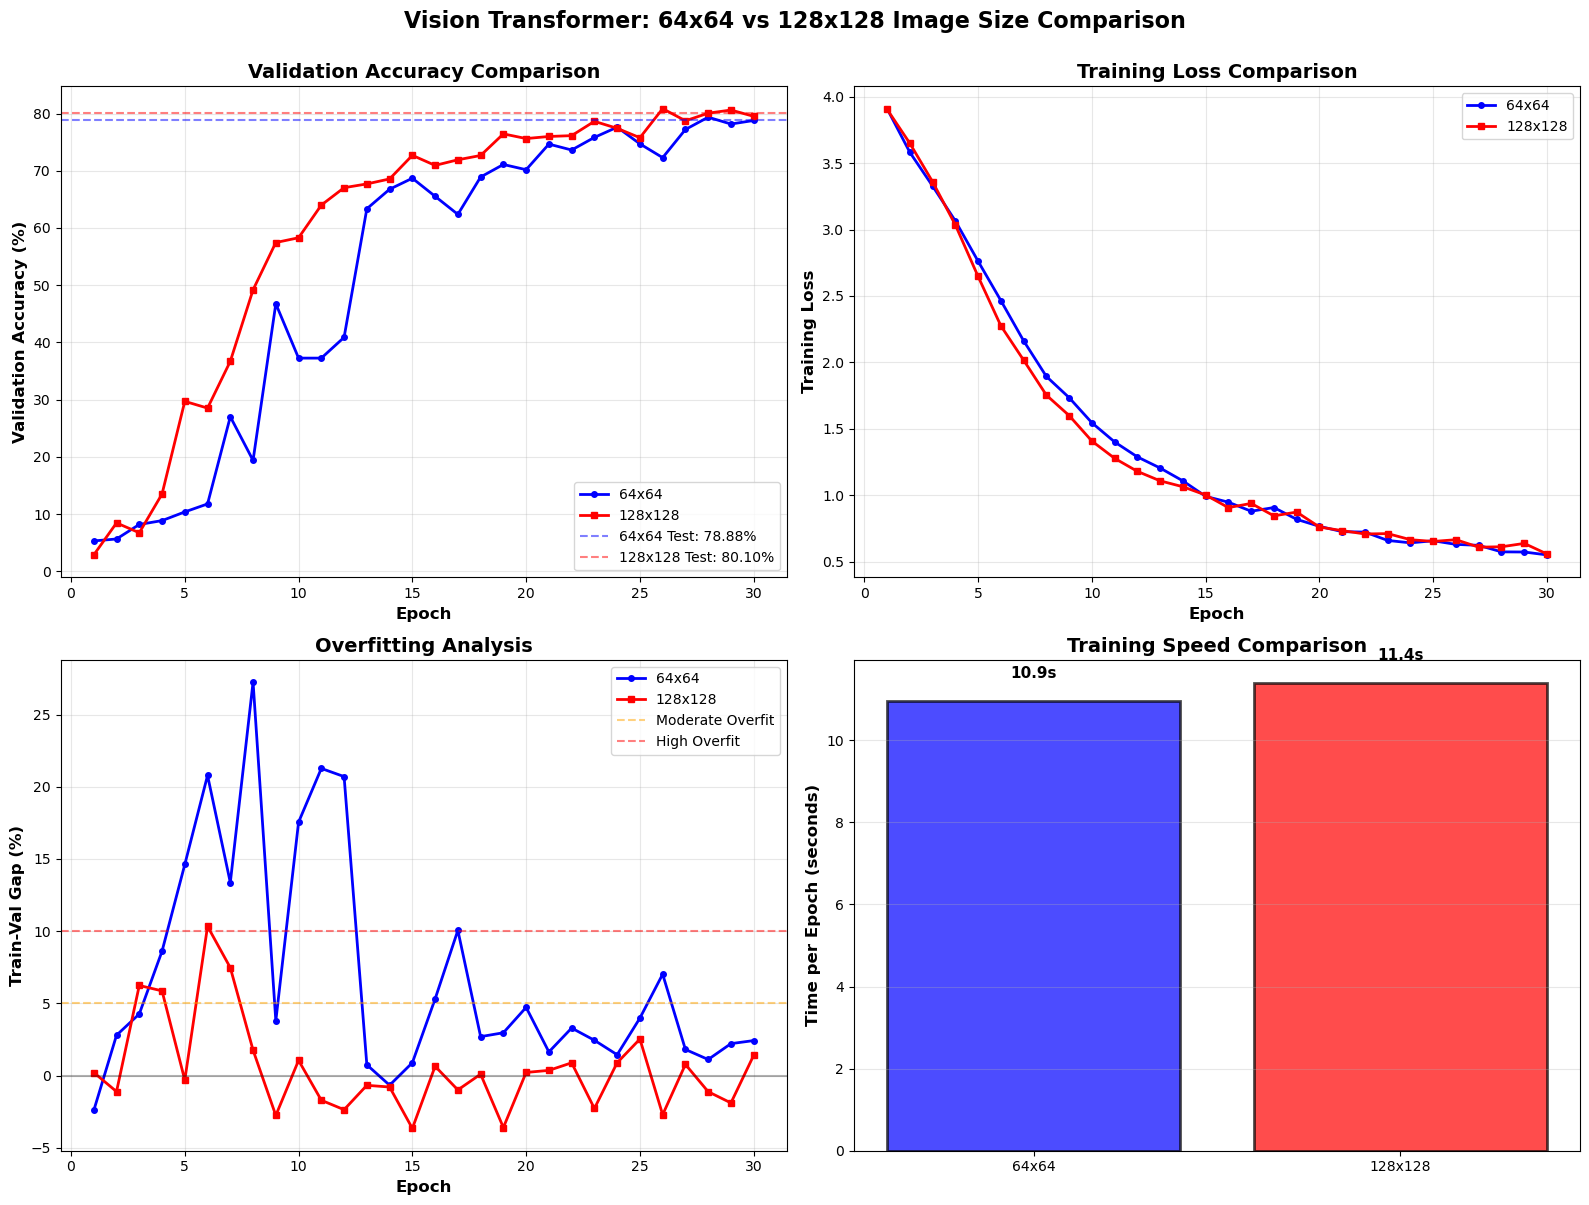

In [22]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Validation Accuracy Comparison
epochs_64 = range(1, len(history_64['val_acc']) + 1)
epochs_128 = range(1, len(history_128['val_acc']) + 1)

axes[0, 0].plot(epochs_64, history_64['val_acc'], 'b-', linewidth=2, label='64x64', marker='o', markersize=4)
axes[0, 0].plot(epochs_128, history_128['val_acc'], 'r-', linewidth=2, label='128x128', marker='s', markersize=4)
axes[0, 0].axhline(y=test_acc_64, color='b', linestyle='--', alpha=0.5, label=f'64x64 Test: {test_acc_64:.2f}%')
axes[0, 0].axhline(y=test_acc_128, color='r', linestyle='--', alpha=0.5, label=f'128x128 Test: {test_acc_128:.2f}%')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Training Loss Comparison
axes[0, 1].plot(epochs_64, history_64['train_loss'], 'b-', linewidth=2, label='64x64', marker='o', markersize=4)
axes[0, 1].plot(epochs_128, history_128['train_loss'], 'r-', linewidth=2, label='128x128', marker='s', markersize=4)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Training Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Overfitting Analysis (Train-Val Gap)
gap_64 = [history_64['train_acc'][i] - history_64['val_acc'][i] for i in range(len(history_64['train_acc']))]
gap_128 = [history_128['train_acc'][i] - history_128['val_acc'][i] for i in range(len(history_128['train_acc']))]

axes[1, 0].plot(epochs_64, gap_64, 'b-', linewidth=2, label='64x64', marker='o', markersize=4)
axes[1, 0].plot(epochs_128, gap_128, 'r-', linewidth=2, label='128x128', marker='s', markersize=4)
axes[1, 0].axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='Moderate Overfit')
axes[1, 0].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='High Overfit')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Train-Val Gap (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Training Time per Epoch
axes[1, 1].bar(['64x64', '128x128'], 
               [np.mean(history_64['epoch_times']), np.mean(history_128['epoch_times'])],
               color=['blue', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Time per Epoch (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Training Speed Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate([np.mean(history_64['epoch_times']), np.mean(history_128['epoch_times'])]):
    axes[1, 1].text(i, v + 0.5, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Vision Transformer: 64x64 vs 128x128 Image Size Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Final Performance Bar Chart

/tmp/ipykernel_9580/2716311229.py:52: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


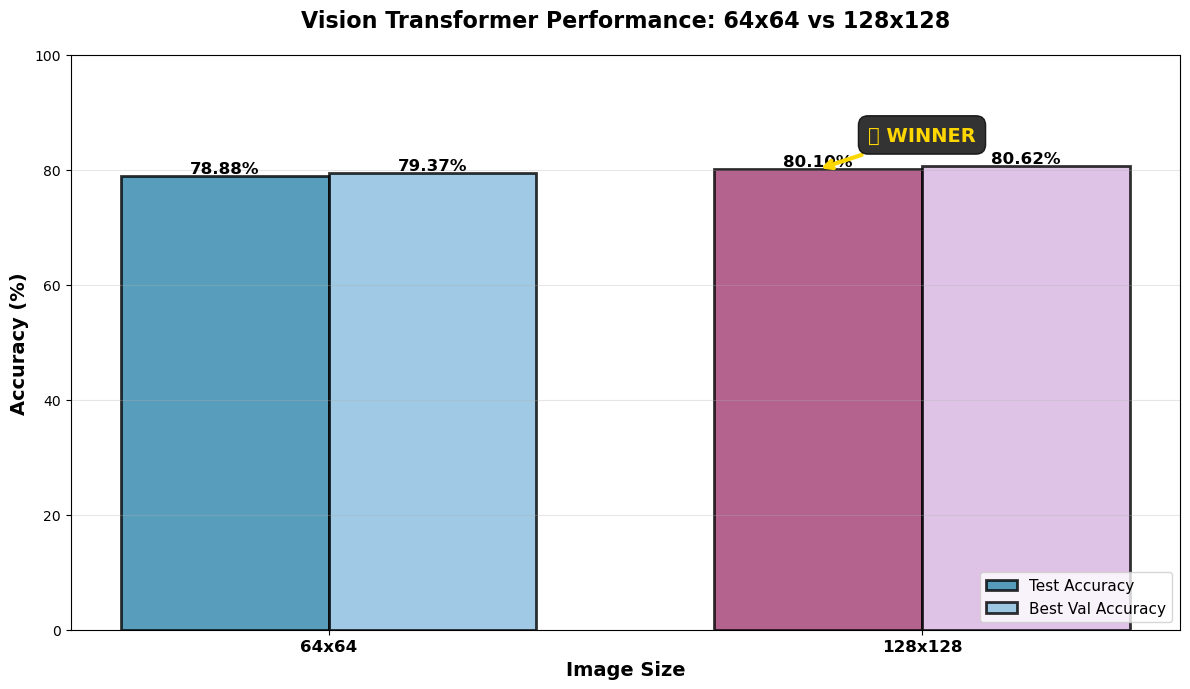


📊 Visualization complete!


In [23]:
# Final comparison bar chart
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(2)
width = 0.35

# Test accuracy bars
bars1 = ax.bar(x - width/2, [test_acc_64, test_acc_128], width, 
               label='Test Accuracy', color=['#2E86AB', '#A23B72'], 
               edgecolor='black', linewidth=2, alpha=0.8)

# Validation accuracy bars
bars2 = ax.bar(x + width/2, [best_val_acc_64, best_val_acc_128], width,
               label='Best Val Accuracy', color=['#87BCDE', '#D8B4E2'],
               edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_xlabel('Image Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Vision Transformer Performance: 64x64 vs 128x128', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['64x64', '128x128'], fontsize=12, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 100])

# Add winner annotation
if test_acc_64 > test_acc_128:
    winner_idx = 0
    winner_acc = test_acc_64
else:
    winner_idx = 1
    winner_acc = test_acc_128

ax.annotate('🏆 WINNER', 
            xy=(x[winner_idx] - width/2, winner_acc), 
            xytext=(x[winner_idx], winner_acc + 5),
            fontsize=14, fontweight='bold', color='gold',
            ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.8),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                          color='gold', lw=3))

plt.tight_layout()
plt.show()

print("\n📊 Visualization complete!")

## 10. Key Insights and Recommendations

In [24]:
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

print("\n1️⃣ ACCURACY:")
print(f"   64x64:  Test={test_acc_64:.2f}%, Val={best_val_acc_64:.2f}%")
print(f"   128x128: Test={test_acc_128:.2f}%, Val={best_val_acc_128:.2f}%")
print(f"   Difference: {abs(test_acc_64 - test_acc_128):.2f}%")

print("\n2️⃣ TRAINING EFFICIENCY:")
print(f"   64x64:  {np.mean(history_64['epoch_times']):.1f}s/epoch, {total_time_64/60:.1f} min total")
print(f"   128x128: {np.mean(history_128['epoch_times']):.1f}s/epoch, {total_time_128/60:.1f} min total")
speedup = np.mean(history_128['epoch_times']) / np.mean(history_64['epoch_times'])
print(f"   Speedup: 64x64 is {speedup:.2f}x faster per epoch")

print("\n3️⃣ OVERFITTING:")
final_gap_64 = history_64['train_acc'][-1] - history_64['val_acc'][-1]
final_gap_128 = history_128['train_acc'][-1] - history_128['val_acc'][-1]
print(f"   64x64 Train-Val Gap:  {final_gap_64:.2f}%")
print(f"   128x128 Train-Val Gap: {final_gap_128:.2f}%")
if final_gap_128 > final_gap_64 + 2:
    print("   ⚠️ 128x128 shows more overfitting")
elif final_gap_64 > final_gap_128 + 2:
    print("   ⚠️ 64x64 shows more overfitting")
else:
    print("   ✓ Similar overfitting levels")

print("\n4️⃣ MODEL COMPLEXITY:")
print(f"   64x64 Parameters:  {total_params_64:,}")
print(f"   128x128 Parameters: {total_params_128:,}")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

if test_acc_64 > test_acc_128 + 1:
    print("\n✅ USE 64x64:")
    print(f"   • Better test accuracy ({test_acc_64:.2f}% vs {test_acc_128:.2f}%)")
    print(f"   • {speedup:.1f}x faster training")
    print("   • Less risk of overfitting")
elif test_acc_128 > test_acc_64 + 1:
    print("\n✅ USE 128x128:")
    print(f"   • Better test accuracy ({test_acc_128:.2f}% vs {test_acc_64:.2f}%)")
    print("   • Worth the extra training time")
else:
    print("\n✅ USE 64x64 (Marginal accuracy difference):")
    print(f"   • Similar accuracy ({test_acc_64:.2f}% vs {test_acc_128:.2f}%)")
    print(f"   • {speedup:.1f}x faster training is significant advantage")
    print("   • More efficient for deployment")

print("\n" + "="*70)


KEY INSIGHTS

1️⃣ ACCURACY:
   64x64:  Test=78.88%, Val=79.37%
   128x128: Test=80.10%, Val=80.62%
   Difference: 1.23%

2️⃣ TRAINING EFFICIENCY:
   64x64:  10.9s/epoch, 5.5 min total
   128x128: 11.4s/epoch, 5.7 min total
   Speedup: 64x64 is 1.04x faster per epoch

3️⃣ OVERFITTING:
   64x64 Train-Val Gap:  2.42%
   128x128 Train-Val Gap: 1.40%
   ✓ Similar overfitting levels

4️⃣ MODEL COMPLEXITY:
   64x64 Parameters:  5,401,781
   128x128 Parameters: 5,400,437

RECOMMENDATION

✅ USE 128x128:
   • Better test accuracy (80.10% vs 78.88%)
   • Worth the extra training time



## 11. Summary

This experiment compared Vision Transformer performance on 64x64 vs 128x128 images.

### What We Measured:
1. **Test Accuracy** - Final classification performance
2. **Validation Accuracy** - Best accuracy during training
3. **Training Time** - Time per epoch and total training time
4. **Overfitting** - Train-validation gap analysis
5. **Convergence** - How quickly models reached optimal performance

### Key Takeaways:
- Higher resolution doesn't always mean better accuracy for Vision Transformers
- Training time increases significantly with image size
- Model parameters remain similar (depends on patch size, not image size)
- Overfitting risk may increase with higher resolution on limited data

### Next Steps:
1. Update main ViT notebook to use optimal image size
2. Consider testing 96x96 as a middle ground
3. Experiment with different patch sizes
4. Try data augmentation to help larger models

---

**Experiment Date**: 2025  
**Dataset**: AlphaNum2 (Alphanumeric Characters)  
**Model**: Vision Transformer (ViT-Tiny)